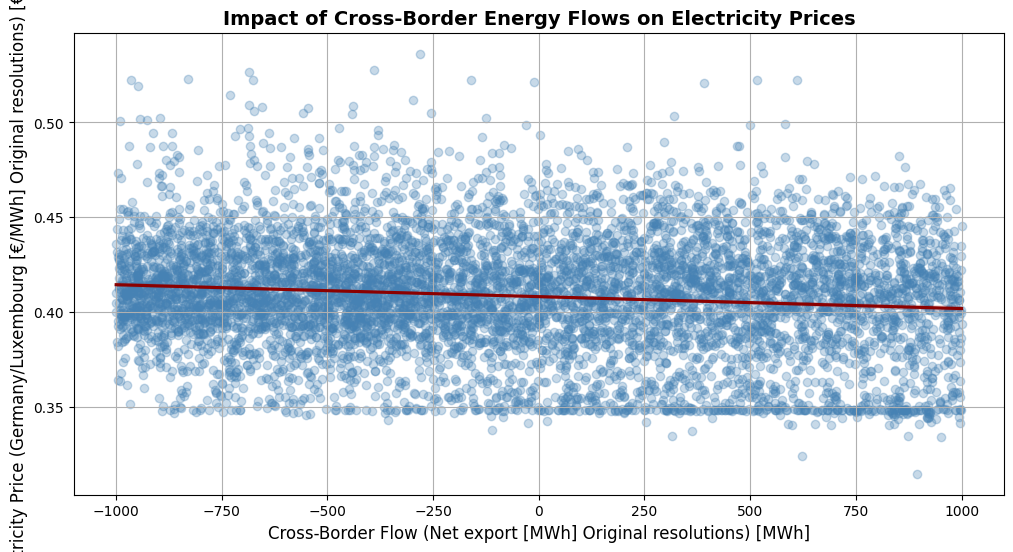

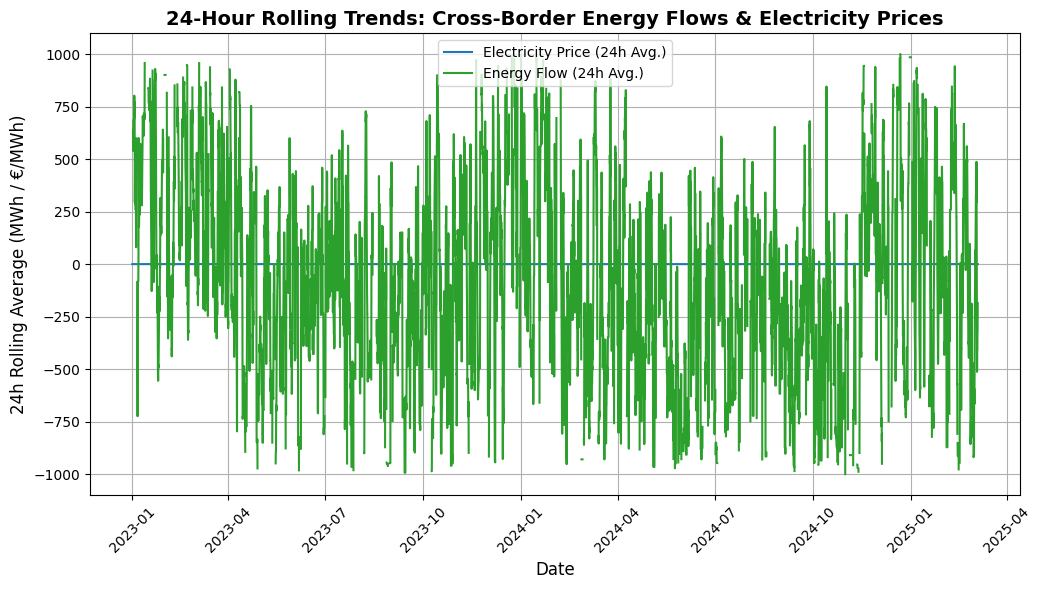

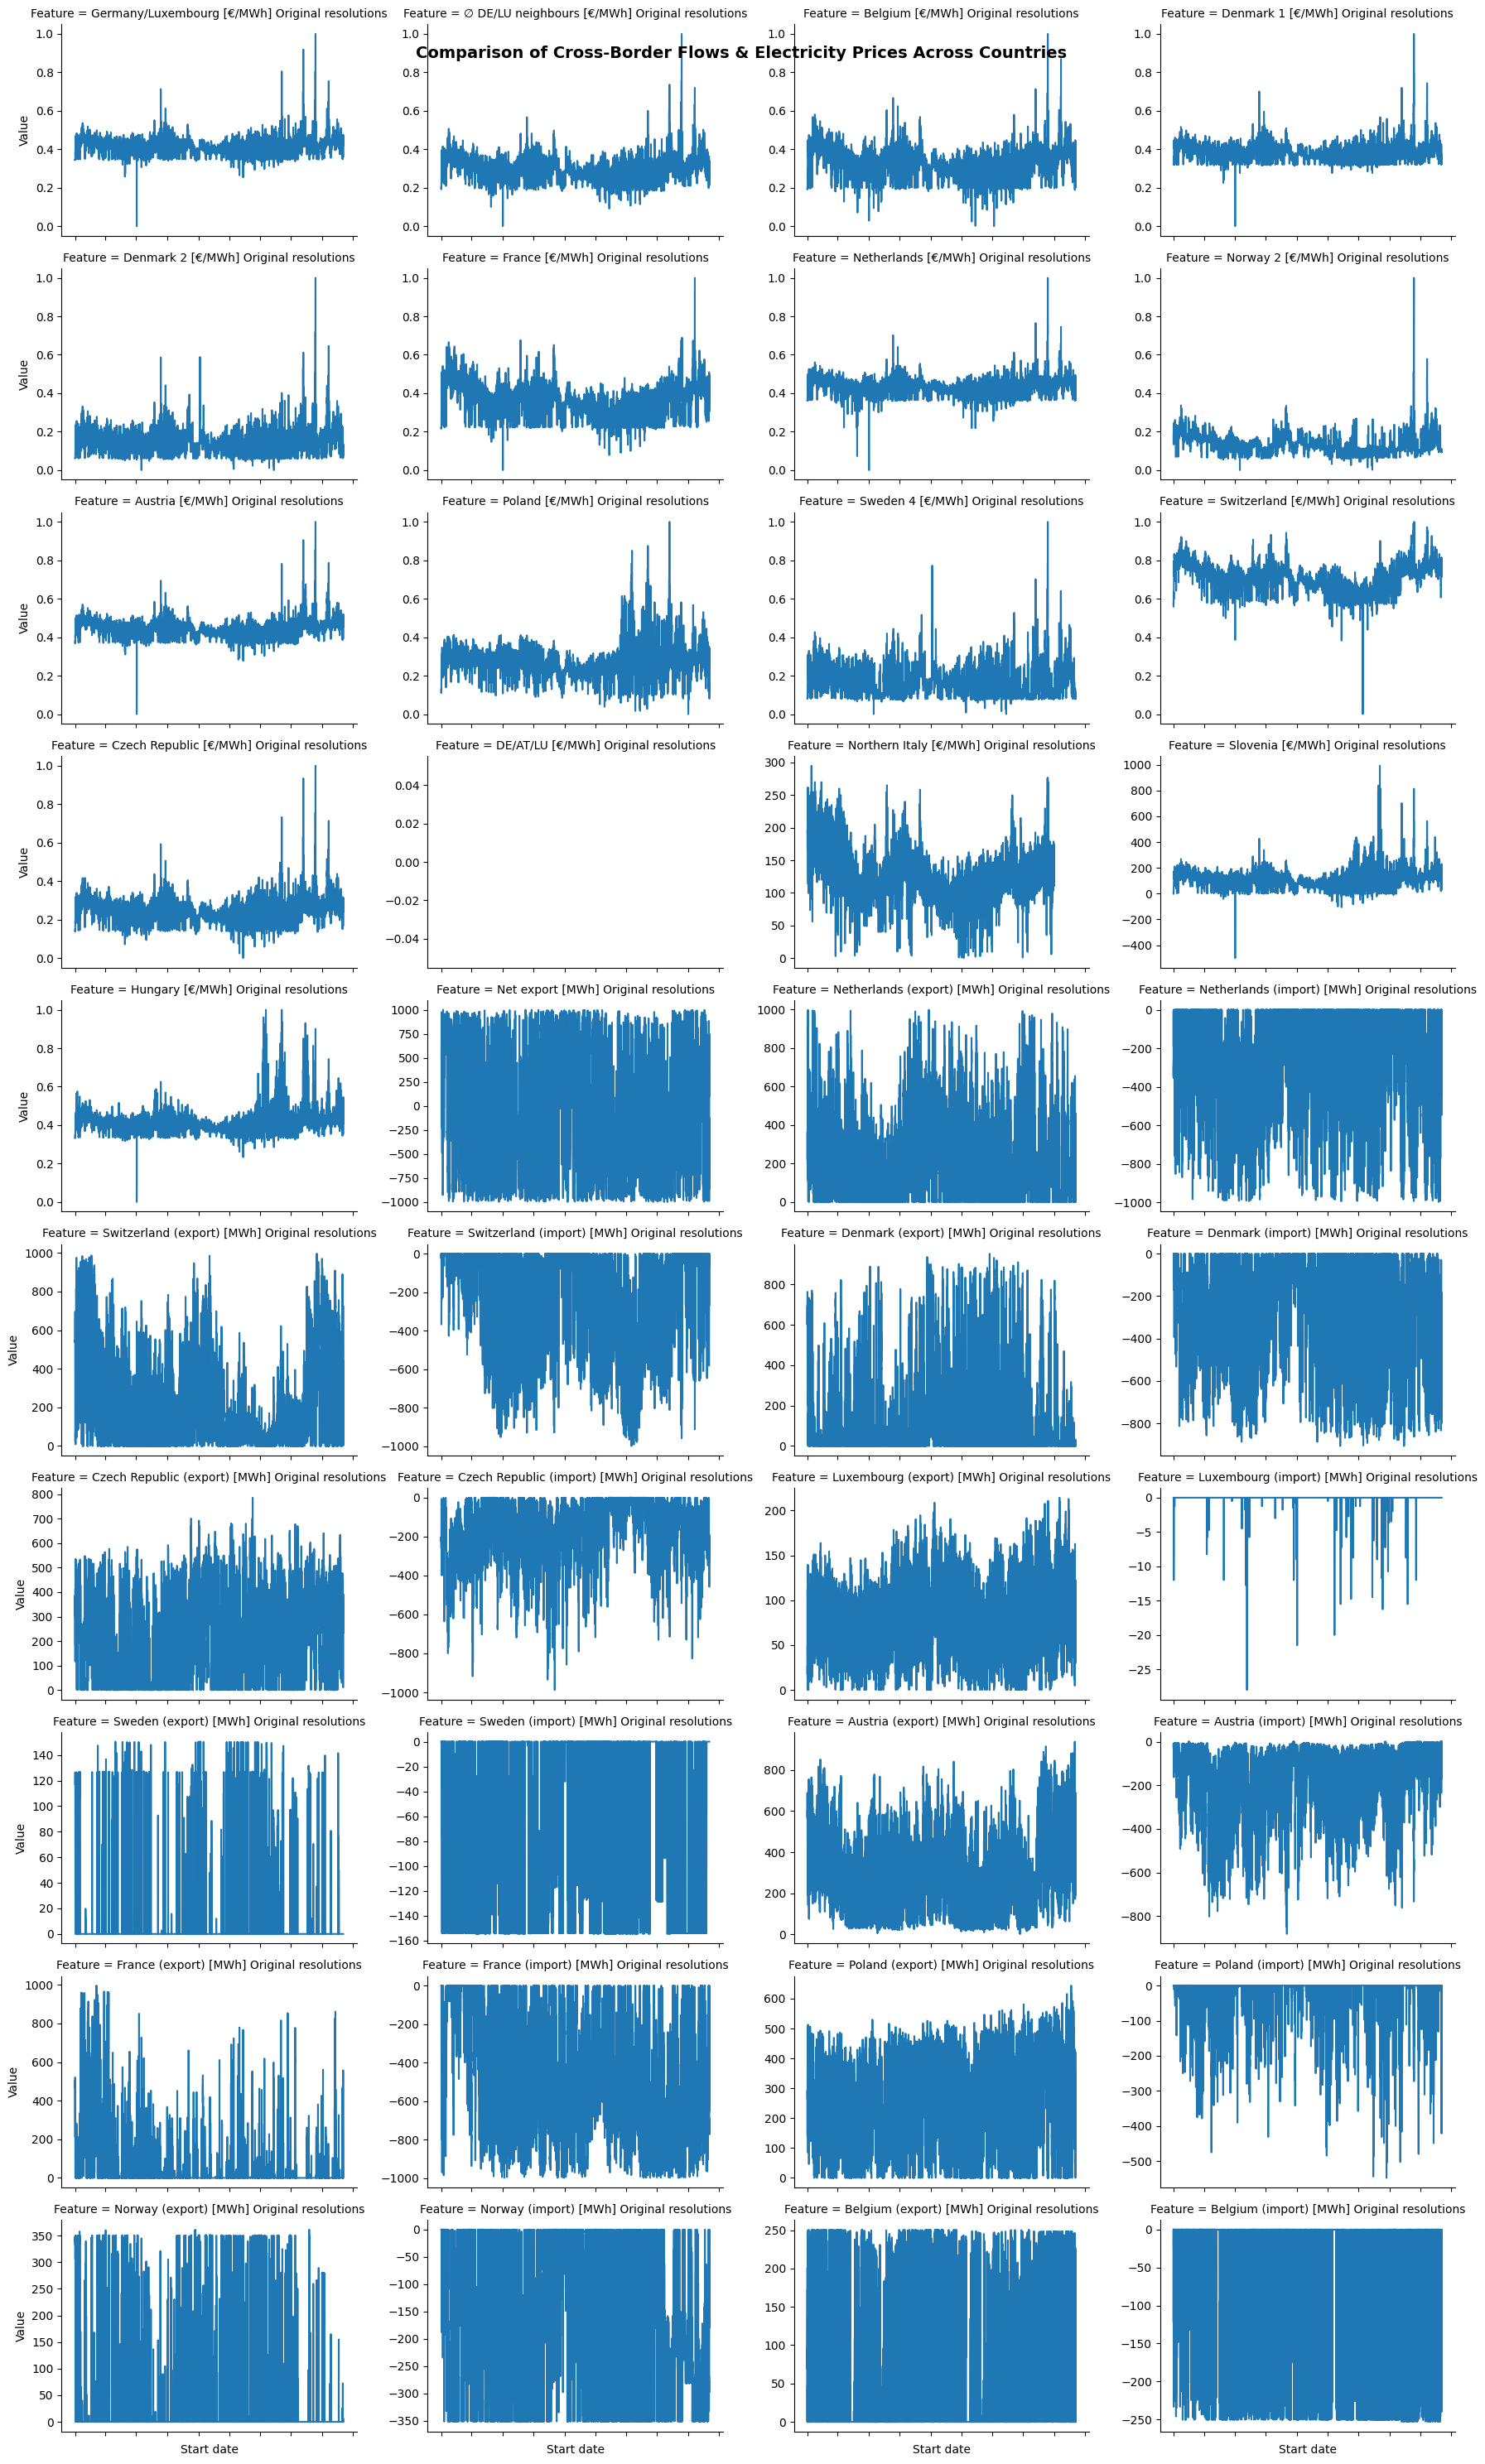

✅ Plots saved in '../plots' directory.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define paths
PLOTS_DIR = "../plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

# Load datasets
flows_file = "../data/refined_files/refined_cleaned_Cross-border_physical_flows_202301010000_202503050000_Quarterhour.csv"
price_file = "../data/refined_files/refined_cleaned_Day-ahead_prices_202301010000_202503050000_Hour.csv"

df_flows = pd.read_csv(flows_file, delimiter=",", low_memory=False)
df_price = pd.read_csv(price_file, delimiter=",", low_memory=False)

# Convert time column to datetime
df_flows["Start date"] = pd.to_datetime(df_flows["Start date"], errors="coerce")
df_price["Start date"] = pd.to_datetime(df_price["Start date"], errors="coerce")

# Merge datasets
df_merged = df_price.merge(df_flows, on="Start date", how="inner")

# Select price and flow columns
price_columns = [col for col in df_price.columns if "€/MWh" in col]
flow_columns = [col for col in df_flows.columns if "[MWh]" in col]

# Convert columns to numeric
df_merged[price_columns] = df_merged[price_columns].apply(pd.to_numeric, errors="coerce")
df_merged[flow_columns] = df_merged[flow_columns].apply(pd.to_numeric, errors="coerce")

# Select a sample country for detailed analysis
country_price = price_columns[0]  # First country price column (adjust as needed)
flow_column = flow_columns[0]  # First cross-border flow column (adjust as needed)

# **1️⃣ Scatter Plot: Cross-Border Flows vs. Electricity Prices**
plt.figure(figsize=(12, 6))
sns.regplot(
    x=df_merged[flow_column], 
    y=df_merged[country_price], 
    scatter_kws={"alpha": 0.3, "color": "steelblue"}, 
    line_kws={"color": "darkred"}
)
plt.xlabel(f"Cross-Border Flow ({flow_column}) [MWh]", fontsize=12)
plt.ylabel(f"Electricity Price ({country_price}) [€/MWh]", fontsize=12)
plt.title("Impact of Cross-Border Energy Flows on Electricity Prices", fontsize=14, fontweight="bold")
plt.grid()
plt.savefig(os.path.join(PLOTS_DIR, "scatter_cross_border_flows_vs_price.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# **2️⃣ Rolling Average Trends (Time Series)**
df_merged["Rolling_Price"] = df_merged[country_price].rolling(window=24, min_periods=1).mean()
df_merged["Rolling_Flow"] = df_merged[flow_column].rolling(window=24, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_merged["Start date"], df_merged["Rolling_Price"], label="Electricity Price (24h Avg.)", color="#1f77b4")
plt.plot(df_merged["Start date"], df_merged["Rolling_Flow"], label="Energy Flow (24h Avg.)", color="#2ca02c")
plt.xlabel("Date", fontsize=12)
plt.ylabel("24h Rolling Average (MWh / €/MWh)", fontsize=12)
plt.title("24-Hour Rolling Trends: Cross-Border Energy Flows & Electricity Prices", fontsize=14, fontweight="bold")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.savefig(os.path.join(PLOTS_DIR, "trend_rolling_avg_flows_vs_price.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# **3️⃣ Country-Wise Facet Grid**
melted_df = df_merged.melt(id_vars=["Start date"], value_vars=price_columns + flow_columns, var_name="Feature", value_name="Value")

g = sns.FacetGrid(melted_df, col="Feature", col_wrap=4, sharex=True, sharey=False, height=3, aspect=1.5, palette="coolwarm")
g.map_dataframe(sns.lineplot, x="Start date", y="Value")
g.set_xticklabels(rotation=45)
g.fig.suptitle("Comparison of Cross-Border Flows & Electricity Prices Across Countries", fontsize=14, fontweight="bold")
plt.savefig(os.path.join(PLOTS_DIR, "facetgrid_cross_border_flows_vs_prices.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("✅ Plots saved in '../plots' directory.")
